In [2]:
from math import log, sqrt, exp
from scipy import stats

def bsm_call_value(S0, K, T, r, sigma):
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    return value

def bsm_vega(S0, K, T, r, sigma):
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    vega = S0 * stats.norm.cdf(d1, 0.0, 1.0) * sqrt(T)
    return vega

def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est, it=100):
    for i in range(it):
        sigma_est -= ((bsm_call_value(S0, K, T, r, sigma_est) - C0) / bsm_vega(S0, K, T, r, sigma_est))
    return sigma_est


In [7]:
import pandas as pd

h5 = pd.HDFStore('./data/vstoxx_data_31032014.h5', 'r')
futures_data = h5['futures_data'] # VSTOXX futures data
options_data = h5['options_data'] # VSTOXX call option data
h5.close()


In [17]:
V0 = 17.6639
r = 0.01

In [58]:
tol = 0.5
options_data['IMP_VOL'] = 0.0

for option in options_data.index:
    forward = futures_data[futures_data['MATURITY'] == options_data.loc[option]['MATURITY']]['PRICE'].values[0]
    if(forward * (1-tol) < options_data.loc[option]['STRIKE'] < forward * (1+tol)):
        imp_vol = bsm_call_imp_vol(
            V0, 
            options_data.loc[option]['STRIKE'], 
            options_data.loc[option]['TTM'], 
            r, 
            options_data.loc[option]['PRICE'], 
            2.0)
        options_data['IMP_VOL'].loc[option] = imp_vol


In [59]:
plot_data = options_data[options_data['IMP_VOL'] > 0.0]

In [60]:
plot_data.head(10)

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM,IMP_VOL
46178,2014-03-31,2014,4,C,9.0,8.85,2014-04-18,0.049,2.083386
46179,2014-03-31,2014,4,C,10.0,7.85,2014-04-18,0.049,1.804194
46180,2014-03-31,2014,4,C,11.0,6.85,2014-04-18,0.049,1.550283
46181,2014-03-31,2014,4,C,12.0,5.85,2014-04-18,0.049,1.316103
46182,2014-03-31,2014,4,C,13.0,4.85,2014-04-18,0.049,1.097184
46183,2014-03-31,2014,4,C,14.0,3.85,2014-04-18,0.049,0.889581
46184,2014-03-31,2014,4,C,15.0,2.90,2014-04-18,0.049,0.748630
46185,2014-03-31,2014,4,C,16.0,2.00,2014-04-18,0.049,0.630958
46186,2014-03-31,2014,4,C,17.0,1.35,2014-04-18,0.049,0.639297
46187,2014-03-31,2014,4,C,18.0,0.95,2014-04-18,0.049,0.703208


In [61]:
maturities = sorted(set(options_data['MATURITY']))

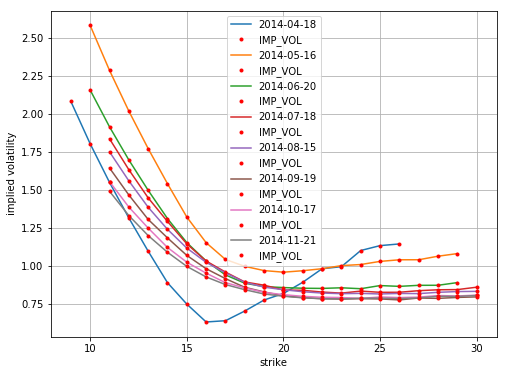

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 6))
for maturity in maturities:
    data = plot_data[plot_data['MATURITY'] == maturity]
    # select data for this maturity
    plt.plot(data['STRIKE'], data['IMP_VOL'], label=maturity.date(),  lw=1.5)
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.')
plt.grid(True)
plt.xlabel('strike')
plt.ylabel('implied volatility')
plt.legend()
plt.show()


In [70]:
keep = ['PRICE', 'IMP_VOL']
group_data = plot_data.groupby(['MATURITY', 'STRIKE'])[keep]
group_data

In [71]:
group_data = group_data.sum()
group_data

PRICE   IMP_VOL
MATURITY   STRIKE                 
2014-04-18 9.0      8.85  2.083386
           10.0     7.85  1.804194
           11.0     6.85  1.550283
           12.0     5.85  1.316103
           13.0     4.85  1.097184
           14.0     3.85  0.889581
           15.0     2.90  0.748630
           16.0     2.00  0.630958
           17.0     1.35  0.639297
           18.0     0.95  0.703208
           19.0     0.70  0.775629
           20.0     0.50  0.818813
           21.0     0.40  0.892494
           22.0     0.35  0.981551
           23.0     0.25  0.995124
           24.0     0.25  1.101613
           25.0     0.20  1.133795
           26.0     0.15  1.144977
2014-05-16 10.0     9.55  2.583783
           11.0     8.55  2.287971
           12.0     7.55  2.019846
           13.0     6.55  1.772845
           14.0     5.55  1.541737
           15.0     4.55  1.321948
           16.0     3.65  1.153127
           17.0     2.90  1.042663
           18.0     2.35  0.997287
           19.0     1.90  0.969408
           20.0     1.55  0.958881
           21.0     1.30  0.968536
...                  ...       ...
2014-10-17 21.0     3.05  0.799966
           22.0     2.75  0.793566
           23.0     2.50  0.791992
           24.0     2.25  0.785962
           25.0     2.10  0.795640
           26.0     1.90  0.791735
           27.0     1.75  0.794615
           28.0     1.65  0.805125
           29.0     1.50  0.802227
           30.0     1.40  0.807714
2014-11-21 11.0    10.25  1.491546
           12.0     9.25  1.331759
           13.0     8.30  1.200063
           14.0     7.40  1.090057
           15.0     6.55  0.997041
           16.0     5.80  0.927519
           17.0     5.15  0.877302
           18.0     4.60  0.843453
           19.0     4.10  0.815015
           20.0     3.70  0.800333
           21.0     3.35  0.790023
           22.0     3.05  0.784194
           23.0     2.80  0.783116
           24.0     2.60  0.787200
           25.0     2.40  0.787899
           26.0     2.20  0.785411
           27.0     2.05  0.789241
           28.0     1.95  0.800016
           29.0     1.80  0.798958
           30.0     1.70  0.805459

[158 rows x 2 columns]